In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

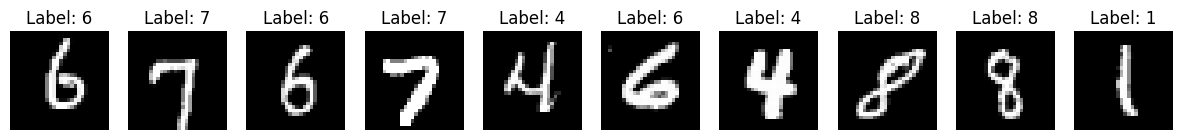

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])


train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [4]:
H_DIM = 256
CODEBOOK_SIZE = 512
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('cpu')

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, H_DIM, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.pre_quant_conv = nn.Sequential(
            nn.Conv2d(H_DIM, H_DIM//2, 3, 1, 1),
            nn.Flatten(),
        )
        self.keys = nn.Embedding(CODEBOOK_SIZE, H_DIM//2)
        self.values = nn.Embedding(CODEBOOK_SIZE, H_DIM//2)
        self.post_quant_conv = nn.Sequential(
            nn.Unflatten(1, (H_DIM//2, 1, 1)),
            nn.Conv2d(H_DIM//2, H_DIM, 3, 1, 1),
        )

        self.beta = 0.2

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(H_DIM, 512, 3, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Sigmoid()
        )

    def to(self, device):
        self.device = device
        return super().to(device)
    
    def forward(self, x):
        # B C H W
        enc = self.encoder(x)
        # B C
        quant_input = self.pre_quant_conv(enc)

        # Quantize
        # dist = torch.cdist(quant_input, self.embedding.weight)
        # min_enc_indices = torch.argmin(dist, dim=-1)
        # quant_out = self.embedding(min_enc_indices)

        scores = torch.einsum('b c, k c -> b k', quant_input, self.keys.weight)
        scores = F.softmax(scores, dim=-1)
        quant_out = torch.einsum('b k, k c -> b c', scores, self.values.weight)


        commitment_loss = self.beta * F.mse_loss(quant_out.detach(), quant_input)
        codebook_loss = F.mse_loss(quant_out, quant_input.detach())
        q_loss = commitment_loss + codebook_loss

        quant_out = quant_input + (quant_out - quant_input).detach()

        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, q_loss

In [5]:
def train(
        model,
        train_set,
        val_set,
        optimizer,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_mses = []
    val_losses = []
    val_mses = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(n_epochs):
        train_set.apply_transform()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        train_mse = 0 
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], train_mse=train_mses[-1], val_mse=val_mses[-1])

            with torch.cuda.amp.autocast():
                decoded, q_loss = model(x)
                mse_loss = F.mse_loss(decoded, x)
                loss = mse_loss + q_loss

            train_loss += loss.item()
            train_mse += mse_loss.item()
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        train_losses.append(train_loss / len(train_set))
        train_mses.append(train_mse / len(train_set))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mse = 0
            for x, _ in val_loader:
                decoded, q_loss = model(x)
                mse_loss = F.mse_loss(decoded, x)
                loss = mse_loss + q_loss
                val_loss += loss.item()
                val_mse += mse_loss.item()

            val_losses.append(val_loss / len(val_set))
            val_mses.append(val_mse / len(val_set))
        
    return train_losses, val_losses, train_mses, val_mses

In [7]:
model = VAE().to(device)
LR = 3e-4
WD = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
EPOCHS = 20
BATCH_SIZE = 32

train_losses, val_losses, train_mses, val_mses = train(model, train_set, val_set, optimizer, EPOCHS, BATCH_SIZE)

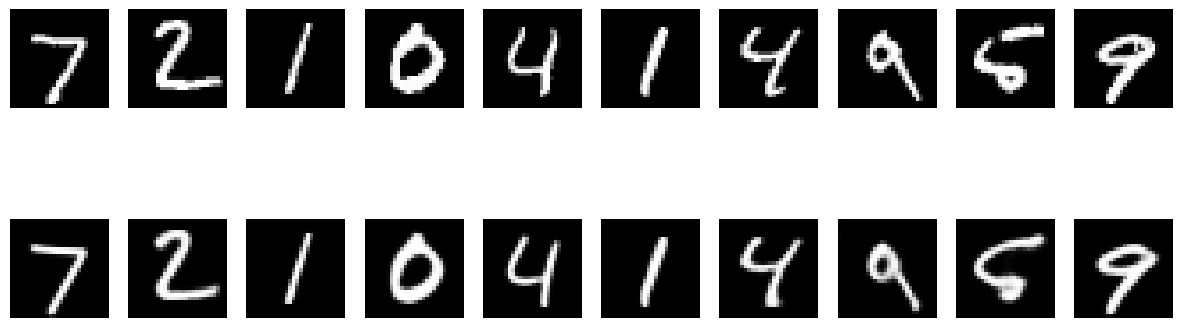

In [9]:
t_images = test_set.transformed_images[:10]
reconstructed, _ = model(t_images)

fig, axes = plt.subplots(2, 10, figsize=(15,5))
for i in range(10):
    axes[0, i].imshow(t_images[i].squeeze().cpu(), cmap='gray')
    axes[1, i].imshow(reconstructed[i].squeeze().cpu().detach(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.show()

In [ ]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
mses = 0

with torch.no_grad():
    model.eval()
    for x, _ in test_loader:
        decoded, _ = model(x)
        mse = F.mse_loss(decoded, x, reduction='none')
        mses += mse.sum(dim=(1,2,3)).mean().item()
    
print('Mean Squared Error:', mses / len(test_set))

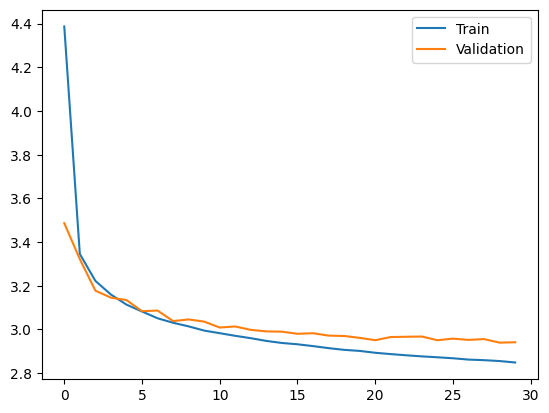

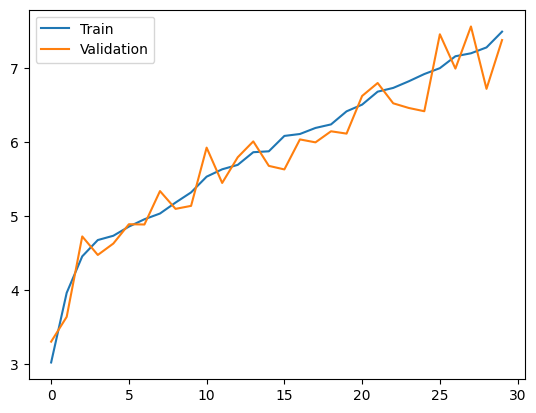

In [43]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()
# Plot mses
plt.plot(train_mses, label='Train')
plt.plot(val_mses, label='Validation')
plt.legend()
plt.show()

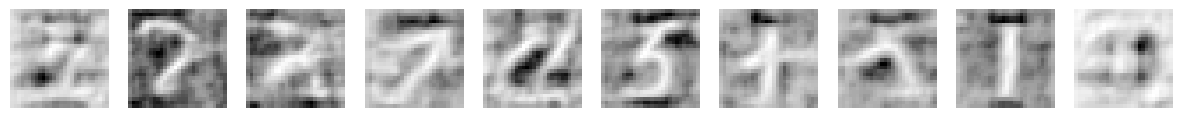

In [44]:
images = model.sample(10, device)
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

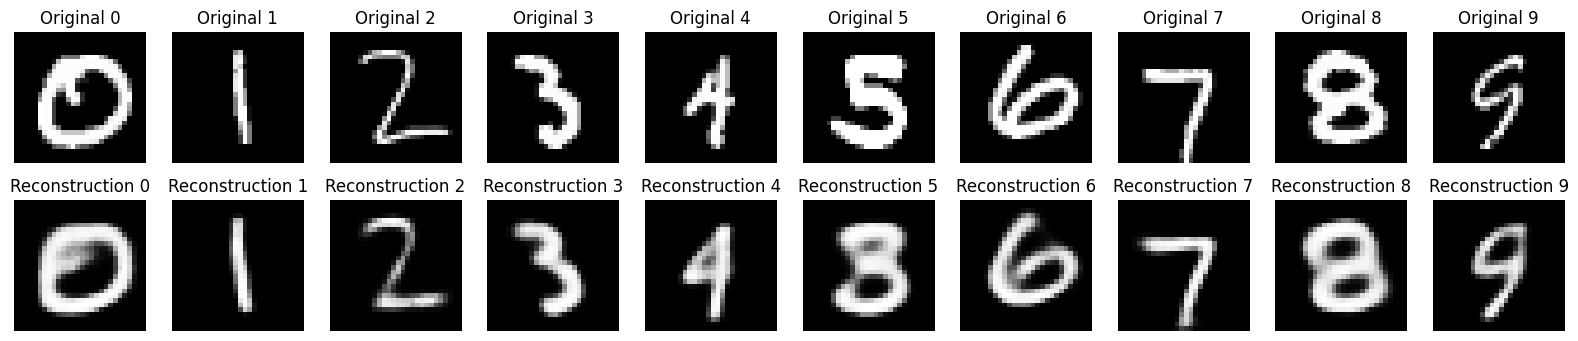

In [40]:
# Collect 1 image per class
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = x_hat.squeeze(0)

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [41]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(20, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            mu, _ = model.encode(x)
            pred = classifier(mu.detach())
            loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            mu, _ = model.encode(x)
            pred = classifier(mu.detach())
            loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [42]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, BATCH_SIZE)

KeyboardInterrupt: 